# **Script para crear variables de texto**
<br>
Nicolas Lozano, Jhan Pulido, Gerardo Rendon, Samuel Narvaez
<br>
2025-05-06

## Limpiamos ambiente y cargamos paquetes

In [26]:
rm(list = ls())

require(pacman)

p_load(
  "ggplot2",
  "tidyverse",
  "dplyr",
  "text2vec",
  "FactoMineR",
  "factoextra",
  "tm",
  "udpipe",
  "pbapply"
)

# Set working directory to the project root
while (tail(strsplit(getwd(), "/")[[1]], 1) != "202510-MLBD-PS3") {
  setwd("..")
}

getwd()

options(
  repr.plot.width  = 10,   # inches  (default is 7)
  repr.plot.height = 6,    # inches  (default is 5)
  repr.plot.res    = 120   # DPI; larger → sharper but heavier files
)

[1] "c:/Users/NicolasLozano/OneDrive - Universidad de los andes/UNIVERSIDAD/9. NOVENO SEMESTRE/BIG DATA/ProblemSets/202510-MLBD-PS3"

## Cargue de datos

In [27]:
train_reg <- readRDS("stores\\provisionales\\train_reg.rds")
train_med <- readRDS("stores\\provisionales\\train_median.rds")

test_reg <- readRDS("stores\\provisionales\\test_reg.rds")
test_med <- readRDS("stores\\provisionales\\test_median.rds")

train_reg$is_test <- 0
train_med$is_test <- 0
test_reg$is_test <- 1
test_med$is_test <- 1

data_reg <- bind_rows(train_reg, test_reg)
data_med <- bind_rows(train_med, test_med)

## Stopwords

In [28]:
stopwords_base <- stopwords("spanish")

stopwords_adicionales <- c(
  "vendo", "venta", "vende", "etc", "carrera", "calle", "casa", "apto", 
  "apartamento", "propiedad", "inmueble", "cuarto", "habitacion", 
  "excelente", "ubicado", "area", "espectacular", "magnifico", "muy", 
  "vivienda", "piso", "alcoba", "bano", "bao", "via", "mas", "consta", 
  "bogota", "santa", "mts", "metro"
)

stopwords_total <- unique(c(stopwords_base, stopwords_adicionales))

## Limpieza de texto

In [29]:
modelo_info <- udpipe_download_model(language = "spanish")

modelo <- udpipe_load_model(file = modelo_info$file_model)

limpiar_texto <- function(texto, stopwords_total) {
  if (is.na(texto) || texto == "") return("")
  
  texto <- tolower(texto)
  texto <- textclean::replace_non_ascii(texto)
  texto <- gsub("[[:punct:]]", " ", texto)
  palabras <- unlist(strsplit(texto, "\\s+"))
  palabras <- palabras[nchar(palabras) >= 3]
  palabras <- palabras[!palabras %in% stopwords_total]
  texto <- paste(palabras, collapse = " ")
  
  return(texto)
}

lematizar_texto <- function(texto, modelo) {
  if (texto == "") return("")
  anotado <- udpipe::udpipe_annotate(modelo, x = texto)
  anotado <- as.data.frame(anotado)
  lemas <- anotado$lemma[!is.na(anotado$lemma)]
  lemas <- lemas[nchar(lemas) >= 3]
  return(paste(lemas, collapse = " "))
}

procesar_texto <- function(texto, stopwords_total, modelo) {
  texto <- limpiar_texto(texto, stopwords_total)        # Primer filtro
  texto <- lematizar_texto(texto, modelo)               # Lematización
  texto <- limpiar_texto(texto, stopwords_total)        # Segundo filtro
  return(texto)
}



 - This model has been trained on version 2.5 of data from https://universaldependencies.org

 - The model is distributed under the CC-BY-SA-NC license: https://creativecommons.org/licenses/by-nc-sa/4.0

 - Visit https://github.com/jwijffels/udpipe.models.ud.2.5 for model license details.

 - For a list of all models and their licenses (most models you can download with this package have either a CC-BY-SA or a CC-BY-SA-NC license) read the documentation at ?udpipe_download_model. For building your own models: visit the documentation by typing vignette('udpipe-train', package = 'udpipe')




In [30]:
data_reg$cleaned_text <- pbapply::pbsapply(data_reg$description, procesar_texto, 
                                       stopwords_total = stopwords_total, 
                                       modelo = modelo)

data_med$cleaned_text <- pbapply::pbsapply(data_med$description, procesar_texto,
                                       stopwords_total = stopwords_total, 
                                       modelo = modelo)

## Bags of Word

In [31]:
crear_bow <- function(data, text_column = "cleaned_text", min_freq = 0.01, ngram = c(1L, 2L)) {
  
  # 1. Tokenizar texto
  it <- itoken(data[[text_column]], progressbar = TRUE)
  
  # 2. Crear vocabulario con n-gramas
  vocab <- create_vocabulary(it, ngram = ngram)
  
  # 3. Filtrar por frecuencia mínima
  vocab <- prune_vocabulary(vocab, term_count_min = min_freq * nrow(data))
  
  # 4. Vectorizador
  vectorizer <- vocab_vectorizer(vocab)
  
  # 5. Crear matriz documento-término
  dtm <- create_dtm(it, vectorizer)
  
  # 6. Convertir a DataFrame
  bow_df <- as.data.frame(as.matrix(dtm))
  colnames(bow_df) <- paste0("d_", colnames(bow_df))  # Prefijo
  
  # 7. Combinar con datos originales
  data_final <- cbind(data, bow_df)
  
  return(data_final)
}

In [32]:
data_reg_large <- crear_bow(data_reg, min_freq = 0.01, ngram = c(1L, 2L))
data_reg_med   <- crear_bow(data_reg, min_freq = 0.05, ngram = c(1L, 2L))
data_reg_light <- crear_bow(data_reg, min_freq = 0.10, ngram = c(1L, 2L))

cat("Variables BoW en data_reg_large: ", ncol(data_reg_large) - ncol(data_reg), "\n")
cat("Variables BoW en data_reg_med:   ", ncol(data_reg_med) - ncol(data_reg), "\n")
cat("Variables BoW en data_reg_light: ", ncol(data_reg_light) - ncol(data_reg), "\n")

data_med_large <- crear_bow(data_med, min_freq = 0.01, ngram = c(1L, 2L))
data_med_med   <- crear_bow(data_med, min_freq = 0.05, ngram = c(1L, 2L))
data_med_light <- crear_bow(data_med, min_freq = 0.10, ngram = c(1L, 2L))

cat("Variables BoW en data_med_large: ", ncol(data_med_large) - ncol(data_med), "\n")
cat("Variables BoW en data_med_med:   ", ncol(data_med_med) - ncol(data_med), "\n")
cat("Variables BoW en data_med_light: ", ncol(data_med_light) - ncol(data_med), "\n")

Variables BoW en data_reg_large:  827 
Variables BoW en data_reg_med:    163 
Variables BoW en data_reg_light:  79 
Variables BoW en data_med_large:  824 
Variables BoW en data_med_med:    165 
Variables BoW en data_med_light:  79 


In [33]:
head(data_reg)

,property_id,city,price,month,year,surface_total,surface_covered,rooms,bedrooms,bathrooms,⋯,lon,title,description,precio_por_mt2,bathroom_per_bedroom,bathroom_per_room,ratio_covered,bedroom_per_room,is_test,cleaned_text
,<chr>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4fa04a187235d7509a43a8cf,Bogotá D.C,5.8e+08,10,2020,180.6663,206.7014,3,3,13,⋯,-74.09965,de casa en los cerezos,cod 2901fr461 de casa multifamiliar 4 pisos garaje y local ubicado sector de los cerezos localidad de engativa agradable vista exterior cuenta con dos terrazas para compartir y disfrutar a una adecuada altura para apreciar la ciudad tiene muy buenos acabados la casa cuenta con 3 apartaestudios cada uno cuenta con su cocina totalmente amoblada y un bano la casa cuenta en total con 5 banos un banos en cada apartaestudio uno en garaje y otro en el local sala comedor con buenos espacios ademas de eso cuenta con 2 terrazas para disfrutar un bbq 3 apartaestudios totalmente independientes local totalmente independiente ubicacion con acceso cerca a la calle 80 a pocas cuadras de av cali o av cra 86 centros comerciales portal 80 y titan restaurantes parques cercanos colegios y universidades,3.210338,4.333333,4.3333333,1.144106,1.0000000,0,cod 2901fr461 multifamiliar garaje local sector cerezo localidad engativo agradable vista exterior contar dos terraza compartir disfrutar adecuado altura apreciar ciudad buen acabado contar apartaestudio cada contar cocina totalmente amoblado contar total cada apartaestudio garaje local sala comedor buen espacio adema contar terraza disfrutar bbq apartaestudio totalmente independiente local totalmente independiente ubicacion acceso cerca cuadra cali centro comercial portal titar restaurante parque cercano colegio universidad
2,f9cfbb306af543a759c1f3f2,Bogotá D.C,6.0e+08,10,2020,304.3739,329.0327,9,9,13,⋯,-74.13164,casa en floralia bogota,casa en o en el barrio floralia en la ciudad de bogota consta de pisos construidos 2 area construida 260 mts terraza 140 mts X s casa completa X piso X piso X piso 1 sala comedor cocina 4 dormitorios 3 banos patio de ropas cubierto 3 garajes cubiertos piso 2 sala comedor cocina tipo americano 5 dormitorios 2 banos 4 closets terraza zona de ropas deposito su ubicacion estrategica permite contar con transporte publico cercano colegios tiendas multiproposito y mucho mas,1.971259,1.444444,1.4444444,1.081015,1.0000000,0,barrio floralia ciudad construido construido 260 terraza 140 completo sala comedor cocinar dormitorio patio ropa cubierto garaje cubierto sala comedor cocinar tipo americano dormitorio closet terrazar zona ropas depositar ubicacion estrategico permitir contar transporte publico cercano colegio tienda multipropositar
3,eb32d75b32bc5e8677207fc7,Bogotá D.C,8.0e+08,10,2020,267.8363,292.4311,6,6,13,⋯,-74.14215,casa fontibon a media cuadra de avda ferrocarril,oportunidad salio a la una amplia casa rentable en uno de los mejores sectores de fontibon en bogota rodeada de comercio y edificios residenciales sobre calle amplia a solo media cuadra de la avenida el ferrocarril posee local comercial amplio sobre la via 2 apartaestudios rentando ya alquilados con una alcoba bano y cocineta cada uno adicionalmente la propia casa posee 3 alcobas 1 bano 5 espacios de parqueo para 3 carros y 2 motos de los cuales solo 1 carro tendria servidumbre de parqueo los demas vehiculos quedan libres la casa tiene adicionalmente 2 estudios 2 bodegas patio de ropas cocina sala y comedor independientes y 1 aljibe el tamano del lote es de 316 m2 y sus dimensiones son 14 metros de frente x 22 metros de fondo el uso de suelo es mixto y a la propiedad puede darsele uso comercial y residencial estrato 3 direccion carrera 103 a 2246 fontibon zona 9 bogota ano de construccion 1946 de XXX casas ideal para supermercado u hotel en fontibon bogota el uso de suelo es mixto y a la propiedad puede darsele uso comercial y residencial estrato 3 sobre la mi

## Combinamos columnas que se repiten con diferente nombre

In [34]:
combinar_dummies <- function(data, variable_pairs) {
  data_copy <- data
  
  for (pair in variable_pairs) {
    var1 <- pair[1]
    var2 <- pair[2]
    
    # Verifica si ambas columnas existen
    if (var1 %in% names(data_copy) && var2 %in% names(data_copy)) {
      base <- gsub("d_", "", var1)
      new_col <- paste0("d_", base)
      
      data_copy[[new_col]] <- pmax(data_copy[[var1]], data_copy[[var2]], na.rm = TRUE)
      
      data_copy <- data_copy %>% select(-all_of(c(var1, var2)))
    } else {
      message(paste("Se omitió el par:", var1, "+", var2, "→ no encontrado."))
    }
  }
  
  return(data_copy)
}

Coluumnas equivalentes

In [35]:
variable_pairs <- list(
  
  c("d_iluminacion", "d_iluminado"),
  c("d_saln", "d_salon")
)

In [36]:
data_reg_med_clean <- combinar_dummies(data_reg_med, variable_pairs)

data_med_med_clean <- combinar_dummies(data_med_med, variable_pairs)

Se omitió el par: d_saln + d_salon → no encontrado.



## Reduccion por PCA para seleccionar variables

In [39]:
columnas_excluir <- c("property_id", "price", "city", "month", "year", 
                      "property_type", "operation_type", "lat", "lon", "title", 
                      "description", "cleaned_text", "is_test", "bathroom_per_bedroom", "bathroom_per_room", "ratio_covered","bedroom_per_room","precio_por_mt2")

perform_pca <- function(data, exclude_columns, explained_variance = 0.95) {
  # 1. Separar y filtrar solo numéricas
  X_pca <- data %>%
    select(-all_of(exclude_columns)) %>%
    select(where(is.numeric)) %>%
    mutate(across(everything(), ~ ifelse(is.na(.), median(., na.rm = TRUE), .)))
  
  X_remaining <- data %>% select(all_of(exclude_columns))
  
  # 2. Estandarizar
  pre_proc <- caret::preProcess(X_pca, method = c("center", "scale"))
  X_scaled <- predict(pre_proc, X_pca)
  
  # 3. PCA
  pca_result <- prcomp(X_scaled, center = FALSE, scale. = FALSE)
  
  # 4. Varianza acumulada
  var_cum <- cumsum(pca_result$sdev^2) / sum(pca_result$sdev^2)
  n_componentes <- which(var_cum >= explained_variance)[1]
  
  # 5. Extraer componentes
  pcs <- as.data.frame(pca_result$x[, 1:n_componentes])
  colnames(pcs) <- paste0("PC", 1:n_componentes)
  
  # 6. Combinar
  resultado <- cbind(X_remaining, pcs)
  
  return(list(data = resultado, pca = pca_result, varianza = var_cum))
}                

In [40]:
resultado_pca_reg <- perform_pca(data_reg_med_clean, columnas_excluir, explained_variance = 0.95)
data_reg_med_pca <- resultado_pca_reg$data
modelo_pca_reg <- resultado_pca_reg$pca
var_cum_reg <- resultado_pca_reg$varianza

length(resultado_pca_reg$varianza[resultado_pca_reg$varianza < 0.95]) + 1

resultado_pca_med <- perform_pca(data_med_med_clean, columnas_excluir, explained_variance = 0.95)
data_med_med_pca <- resultado_pca_med$data
modelo_pca_med <- resultado_pca_med$pca
var_cum_med <- resultado_pca_med$varianza

length(resultado_pca_med$varianza[resultado_pca_med$varianza < 0.95]) + 1

[1] 131

[1] 131

In [41]:
limite_componentes_reg <- which(var_cum_reg >= 0.95)[1]
limite_componentes_med <- which(var_cum_med >= 0.95)[1]

Creamos data filtrada

In [43]:
df_varianza_reg <- data.frame(
  Componente = 1:limite_componentes_reg,
  VarianzaAcumulada = var_cum_reg[1:limite_componentes_reg]
)

df_varianza_med <- data.frame(
  Componente = 1:limite_componentes_med,
  VarianzaAcumulada = var_cum_med[1:limite_componentes_med]
)

Graficamos

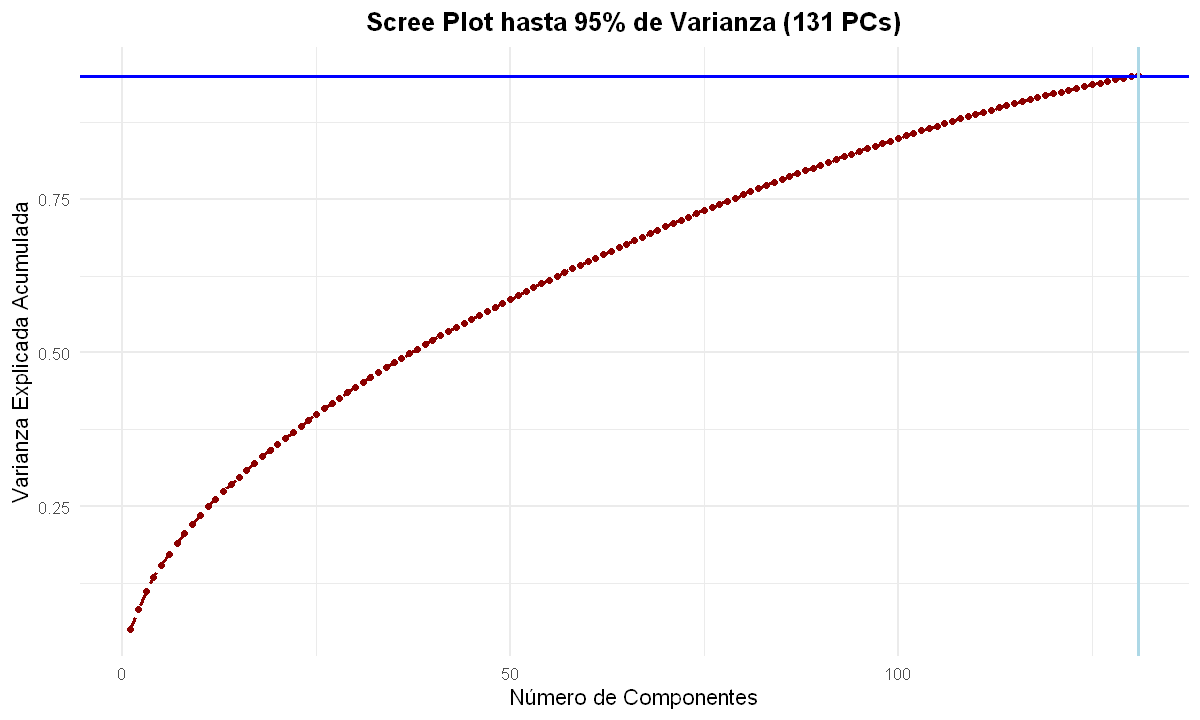

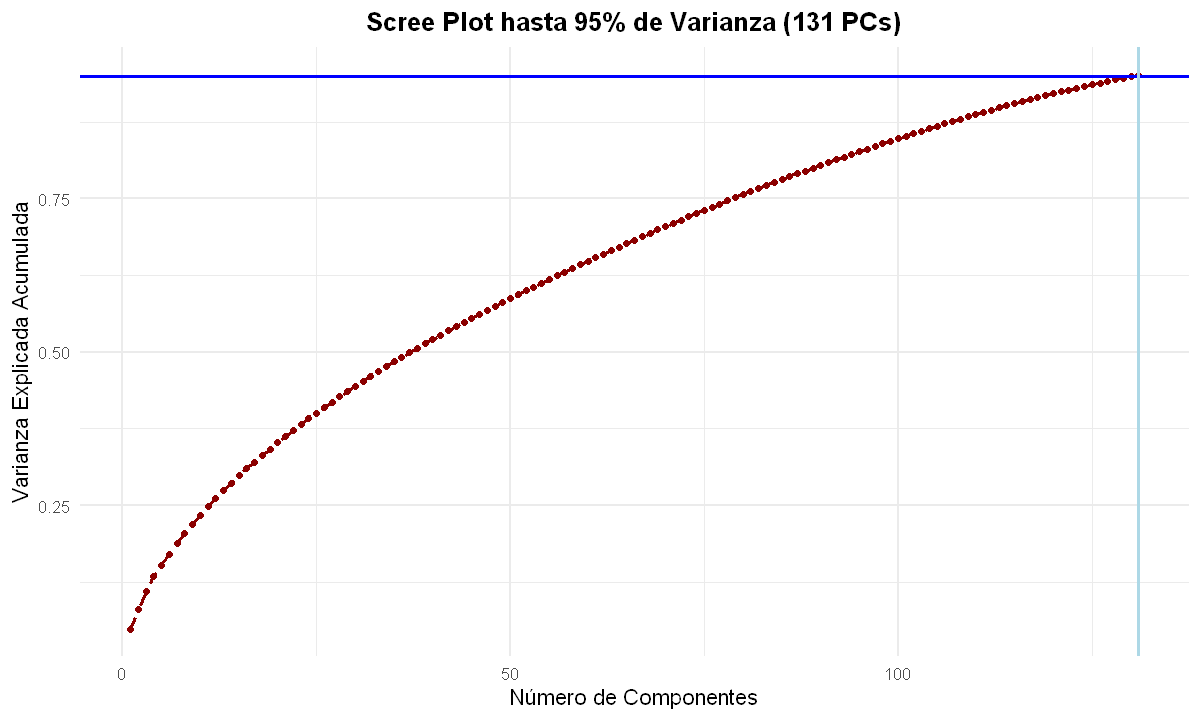

In [45]:
ggplot(df_varianza_reg, aes(x = Componente, y = VarianzaAcumulada)) +
  geom_line(color = "darkred", size = 1, linetype = "dashed") +
  geom_point(color = "darkred", size = 1.5) +
  geom_hline(yintercept = 0.95, color = "blue", size = 1) +
  geom_vline(xintercept = limite_componentes_reg, color = "lightblue", size = 1) +
  labs(
    title = paste("Scree Plot hasta 95% de Varianza (", limite_componentes_reg, " PCs)", sep = ""),
    x = "Número de Componentes",
    y = "Varianza Explicada Acumulada"
  ) +
  theme_minimal(base_size = 13) +
  theme(plot.title = element_text(face = "bold", hjust = 0.5))

ggplot(df_varianza_med, aes(x = Componente, y = VarianzaAcumulada)) +
  geom_line(color = "darkred", size = 1, linetype = "dashed") +
  geom_point(color = "darkred", size = 1.5) +
  geom_hline(yintercept = 0.95, color = "blue", size = 1) +
  geom_vline(xintercept = limite_componentes_med, color = "lightblue", size = 1) +
  labs(
    title = paste("Scree Plot hasta 95% de Varianza (", limite_componentes_med, " PCs)", sep = ""),
    x = "Número de Componentes",
    y = "Varianza Explicada Acumulada"
  ) +
  theme_minimal(base_size = 13) +
  theme(plot.title = element_text(face = "bold", hjust = 0.5))


Seleccionamos componentes

In [46]:
explained_variance_reg <- (modelo_pca_reg$sdev^2) / sum(modelo_pca_reg$sdev^2)

# 2. DataFrame para graficar
df_varianza_ex_reg <- data.frame(
  Componente = 1:length(explained_variance_reg),
  Varianza = explained_variance_reg
)

explained_variance_med <- (modelo_pca_med$sdev^2) / sum(modelo_pca_med$sdev^2)

df_varianza_ex_med <- data.frame(
  Componente = 1:length(explained_variance_med),
  Varianza = explained_variance_med
)

Graficamos

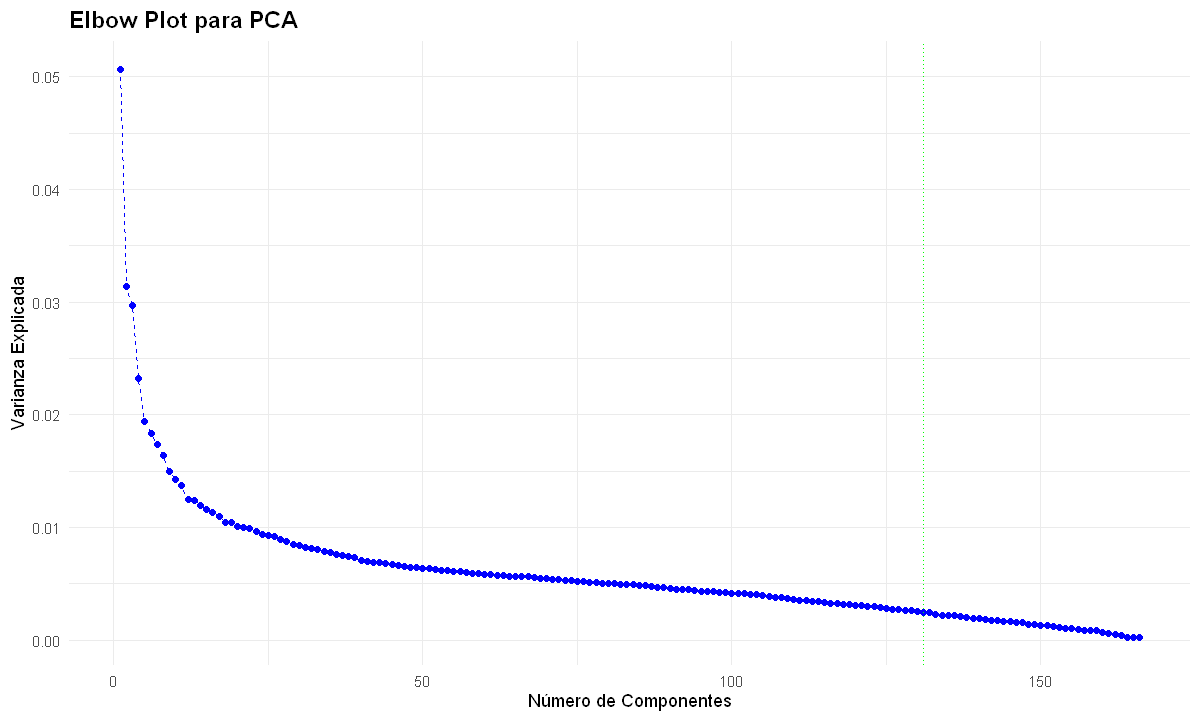

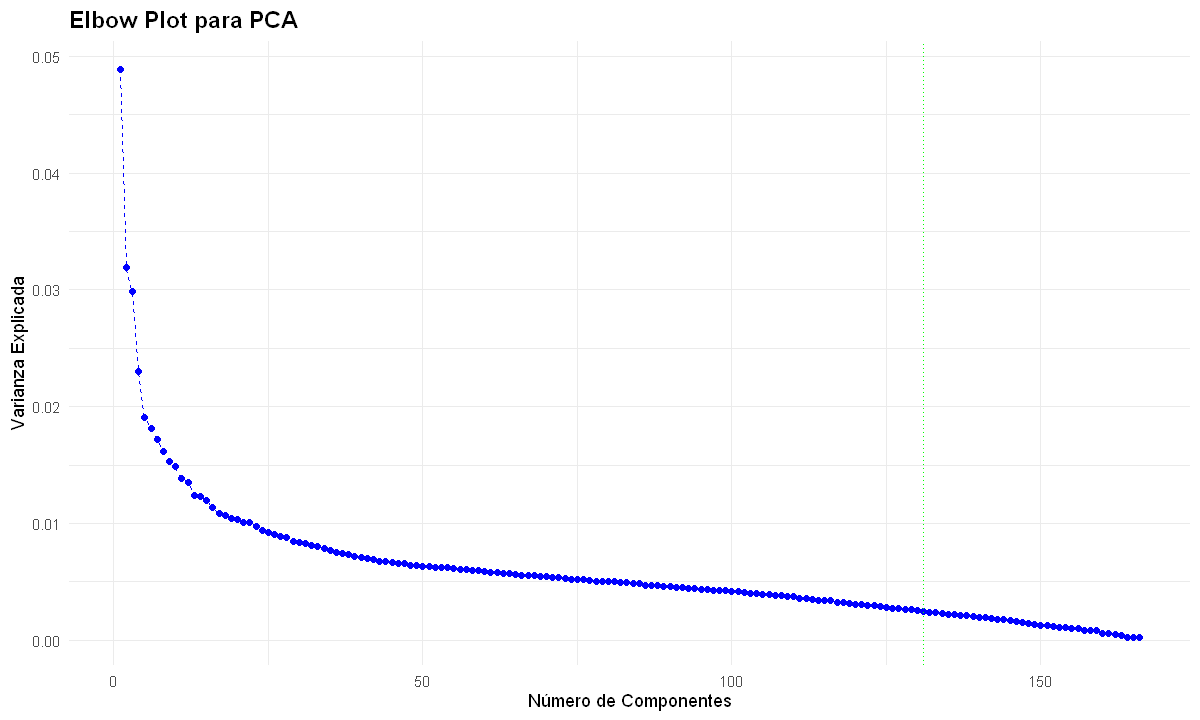

In [47]:
ggplot(df_varianza_ex_reg, aes(x = Componente, y = Varianza)) +
  geom_line(color = "blue", linetype = "dashed") +
  geom_point(color = "blue") +
  geom_vline(xintercept = length(colnames(data_reg_med_pca)) - length(columnas_excluir), 
             color = "green", linetype = "dotted") +
  labs(title = "Elbow Plot para PCA",
       x = "Número de Componentes",
       y = "Varianza Explicada") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14))

ggplot(df_varianza_ex_med, aes(x = Componente, y = Varianza)) +
  geom_line(color = "blue", linetype = "dashed") +
  geom_point(color = "blue") +
  geom_vline(xintercept = length(colnames(data_med_med_pca)) - length(columnas_excluir), 
             color = "green", linetype = "dotted") +
  labs(title = "Elbow Plot para PCA",
       x = "Número de Componentes",
       y = "Varianza Explicada") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14))

In [50]:
pcs_30_reg <- as.data.frame(modelo_pca_reg$x[, 1:30])
colnames(pcs_30_reg) <- paste0("PC", 1:30)

data_pca_30_reg <- cbind(data_reg_med_clean[, columnas_excluir], pcs_30_reg)

str(data_pca_30_reg)
summary(data_pca_30_reg$PC1)

pcs_30_med <- as.data.frame(modelo_pca_med$x[, 1:30])
colnames(pcs_30_med) <- paste0("PC", 1:30)

data_pca_30_med <- cbind(data_med_med_clean[, columnas_excluir], pcs_30_med)

str(data_pca_30_med)
summary(data_pca_30_med$PC1)


'data.frame':	47478 obs. of  48 variables:
 $ property_id         : chr  "4fa04a187235d7509a43a8cf" "f9cfbb306af543a759c1f3f2" "eb32d75b32bc5e8677207fc7" "880a6e7bd74dc2568940d275" ...
 $ price               : num  5.8e+08 6.0e+08 8.0e+08 4.8e+08 8.0e+08 9.5e+08 5.6e+08 4.5e+08 7.2e+08 7.2e+08 ...
 $ city                : chr  "Bogotá D.C" "Bogotá D.C" "Bogotá D.C" "Bogotá D.C" ...
 $ month               : Factor w/ 12 levels "1","2","3","4",..: 10 10 10 10 10 10 10 10 10 10 ...
 $ year                : Factor w/ 3 levels "2019","2020",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ property_type       : Factor w/ 2 levels "Apartamento",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ operation_type      : chr  "Venta" "Venta" "Venta" "Venta" ...
 $ lat                 : num  4.71 4.61 4.68 4.76 4.7 ...
 $ lon                 : num  -74.1 -74.1 -74.1 -74.1 -74.1 ...
 $ title               : chr  "de casa en los cerezos" "casa en floralia bogota" "casa fontibon a media cuadra de avda ferrocarril" "casa en bogota villa de

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-6.18811 -2.06546 -0.07245  0.00000  1.95247 20.05847 

'data.frame':	45691 obs. of  48 variables:
 $ property_id         : chr  "4fa04a187235d7509a43a8cf" "f9cfbb306af543a759c1f3f2" "957a84e8e93ae2b33bc6f61b" "eb32d75b32bc5e8677207fc7" ...
 $ price               : num  5.8e+08 6.0e+08 4.0e+08 8.0e+08 4.8e+08 8.0e+08 9.5e+08 5.6e+08 4.5e+08 7.2e+08 ...
 $ city                : chr  "Bogotá D.C" "Bogotá D.C" "Bogotá D.C" "Bogotá D.C" ...
 $ month               : Factor w/ 12 levels "1","2","3","4",..: 10 10 10 10 10 10 10 10 10 10 ...
 $ year                : Factor w/ 3 levels "2019","2020",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ property_type       : Factor w/ 2 levels "Apartamento",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ operation_type      : chr  "Venta" "Venta" "Venta" "Venta" ...
 $ lat                 : num  4.71 4.61 4.59 4.68 4.76 ...
 $ lon                 : num  -74.1 -74.1 -74.1 -74.1 -74.1 ...
 $ title               : chr  "de casa en los cerezos" "casa en floralia bogota" "de casa en el barrio fatima" "casa fontibon a media cuadra de avda ferroc

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-20.57012  -1.89741   0.06034   0.00000   1.99650   6.05954 

In [51]:
numeros_palabras <- c(
  "un" = 1, "uno" = 1, "primer" = 1, "primero" = 1, "1er" = 1,
  "dos" = 2, "segundo" = 2, "2do" = 2,
  "tres" = 3, "tercero" = 3, "3ro" = 3,
  "cuatro" = 4, "cuarto" = 4, "4to" = 4,
  "cinco" = 5, "quinto" = 5, "5to" = 5,
  "seis" = 6, "sexto" = 6, "6to" = 6,
  "siete" = 7, "septimo" = 7, "7mo" = 7,
  "ocho" = 8, "octavo" = 8, "8vo" = 8,
  "nueve" = 9, "noveno" = 9, "9no" = 9,
  "diez" = 10, "decimo" = 10, "10mo" = 10,
  "once" = 11, "undecimo" = 11, "11mo" = 11,
  "doce" = 12, "duodecimo" = 12, "12mo" = 12,
  "trece" = 13, "13mo" = 13,
  "catorce" = 14, "14mo" = 14,
  "quince" = 15, "15mo" = 15,
  "dieciseis" = 16, "16mo" = 16,
  "diecisiete" = 17, "17mo" = 17,
  "dieciocho" = 18, "18mo" = 18,
  "diecinueve" = 19, "19mo" = 19,
  "veinte" = 20, "20mo" = 20,
  "veintiuno" = 21, "21mo" = 21,
  "veintidos" = 22, "22mo" = 22,
  "veintitres" = 23, "23mo" = 23,
  "veinticuatro" = 24, "24mo" = 24,
  "veinticinco" = 25, "25mo" = 25,
  "veintiseis" = 26, "26mo" = 26,
  "veintisiete" = 27, "27mo" = 27,
  "veintiocho" = 28, "28mo" = 28,
  "veintinueve" = 29, "29mo" = 29,
  "treinta" = 30, "30mo" = 30
)


palabras_habitaciones <- c("habitacion", "cuarto", "alcoba", "dormitorio")
palabras_banos <- c("baño", "aseo", "bano", "bao")
palabras_pisos <- c("piso", "nivel", "planta")
palabras_area <- c("metro", "m2", "mt2")  # ESTA es la que te falta
palabras_parqueadero <- c("garaje", "parqueadero", "parqueo", "estacionamiento")
palabras_ano <- c("ano", "años", "anios", "antiguedad")

In [52]:
convertir_numeros <- function(texto) {
  for (palabra in names(numeros_palabras)) {
    texto <- gsub(paste0("\\b", palabra, "\\b"), numeros_palabras[palabra], texto)
  }
  return(texto)
}

In [53]:
extraer_variable <- function(texto, palabras_clave) {
  patron1 <- paste0("(\\d+)\\s*(?:", paste(palabras_clave, collapse = "|"), ")")
  patron2 <- paste0("(?:", paste(palabras_clave, collapse = "|"), ")\\s*(\\d+)")
  
  match1 <- regexpr(patron1, texto, perl = TRUE)
  match2 <- regexpr(patron2, texto, perl = TRUE)
  
  if (match1[1] != -1) {
    m <- regmatches(texto, match1)
    return(as.numeric(gsub("(\\d+).*", "\\1", m)))
  } else if (match2[1] != -1) {
    m <- regmatches(texto, match2)
    return(as.numeric(gsub(".*?(\\d+)", "\\1", m)))
  } else {
    return(NA)
  }
}

In [54]:
procesar_descripcion <- function(texto) {
  if (is.na(texto)) return(rep(NA, 6))
  
  texto <- tolower(texto)
  texto <- gsub("[áÁ]", "a", texto)
  texto <- gsub("[éÉ]", "e", texto)
  texto <- gsub("[íÍ]", "i", texto)
  texto <- gsub("[óÓ]", "o", texto)
  texto <- gsub("[úÚ]", "u", texto)
  texto <- gsub("ñ", "n", texto)
  
  texto <- convertir_numeros(texto)
  
  num_pisos <- extraer_variable(texto, palabras_pisos)
  num_habitaciones <- extraer_variable(texto, palabras_habitaciones)
  num_banos <- extraer_variable(texto, palabras_banos)
  area_m2 <- extraer_variable(texto, palabras_area)
  num_parqueaderos <- extraer_variable(texto, palabras_parqueadero)
  ano_construccion <- extraer_variable(texto, palabras_ano)
  
  return(as.numeric(c(num_pisos, num_habitaciones, num_banos, area_m2, num_parqueaderos, ano_construccion)))
}

In [55]:
vars_extraidas_reg <- t(sapply(data_reg_med_clean$cleaned_text, procesar_descripcion))
colnames(vars_extraidas_reg) <- c("num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion")

vars_extraidas_med <- t(sapply(data_med_med_clean$cleaned_text, procesar_descripcion))
colnames(vars_extraidas_med) <- c("num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion")

In [56]:
data_reg_med_clean <- cbind(data_reg_med_clean, vars_extraidas_reg)

data_med_med_clean <- cbind(data_med_med_clean, vars_extraidas_med)

In [57]:
colSums(is.na(data_med_med_clean[, c("num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion")]))

colSums(is.na(data_reg_med_clean[, c("num_pisos", "num_habitaciones", "num_banos", "area_m2", "num_parqueaderos", "ano_construccion")]))

num_pisos num_habitaciones        num_banos          area_m2 
           41695            43706            45618            42533 
num_parqueaderos ano_construccion 
           35195            44649

num_pisos num_habitaciones        num_banos          area_m2 
           43069            45354            47395            44143 
num_parqueaderos ano_construccion 
           36392            46361

In [58]:
"property_id" %in% names(data_reg_med_pca)
"property_id" %in% names(data_reg_med_clean)

"property_id" %in% names(data_med_med_pca)
"property_id" %in% names(data_med_med_clean)

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [59]:
vars_texto_reg <- data_reg_med_clean[, c("property_id", "num_pisos", "num_habitaciones",
                                 "num_banos", "area_m2", "num_parqueaderos", "ano_construccion")]

vars_texto_med <- data_med_med_clean[, c("property_id", "num_pisos", "num_habitaciones",
                                 "num_banos", "area_m2", "num_parqueaderos", "ano_construccion")]

In [60]:
data_texto_completa_reg <- data_pca_30_reg %>%
  left_join(vars_texto_reg, by = "property_id")

data_texto_completa_med <- data_pca_30_med %>%
  left_join(vars_texto_med, by = "property_id")

In [61]:
data_texto_train_reg <- data_texto_completa_reg %>% filter(is_test == 0)
data_texto_test_reg <- data_texto_completa_reg %>% filter(is_test == 1)

data_texto_train_med <- data_texto_completa_med %>% filter(is_test == 0)
data_texto_test_med <- data_texto_completa_med %>% filter(is_test == 1)

In [ ]:
saveRDS(data_texto_train_reg, file =  "stores\\provisionales\\data_texto_train_reg.rds")
saveRDS(data_texto_test_reg,  file = "stores\\provisionales\\data_texto_test_reg.rds")

saveRDS(data_texto_train_med, file =  "stores\\provisionales\\data_texto_train_med.rds")
saveRDS(data_texto_test_med,  file = "stores\\provisionales\\data_texto_test_med.rds")